## Case 1: Train different anomaly detection networks dynamically over time

#### MIX MNIST:
Advantages of Automated Meter Reading with Computer Vision 
The implementation of Computer Vision for automated meter reading offers a compelling suite of benefits 

- Real-Time Monitoring: Continuous tracking of pressure, temperature, and liquid levels enables instant detection of fluctuations, preventing potential failures or safety risks. 
- Increased Accuracy: Eliminates human errors in reading analog and digital meters, ensuring precise measurements and reliable data. 
- Enhanced Safety: Reduces the need for manual inspections in hazardous or hard-to-reach locations, minimizing worker exposure to risks. 
- Operational Efficiency: Automates data collection, reducing the need for frequent manual checks and allowing personnel to focus on higher-value tasks. 
- Predictive Maintenance: Provides historical data and trend analysis, helping industries detect anomalies early and schedule maintenance before failures occur. 
- Remote Accessibility: Enables monitoring from centralized control rooms or remote locations, reducing labor costs and improving response times. 


https://imagevision.ai/blog/automated-meter-reading-using-computer-vision-for-industrial-plants-to-enhance-data-logging/?utm_source=chatgpt.com

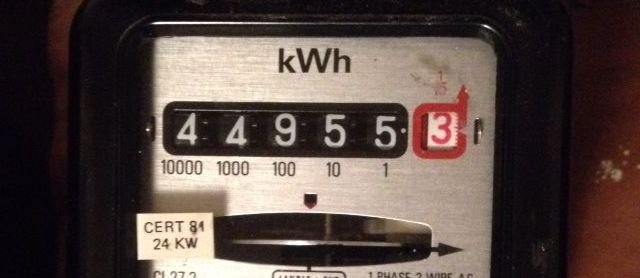
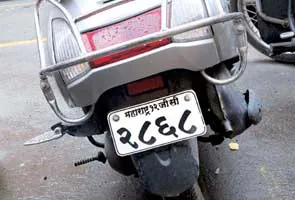

In [ ]:
all_languages = ["Arabic","ARDIS","Bangla","BanglaLekha","Devanagari","EMNIST",
 "Farsi","ISI_Bangla","Kannada","MADBase","Telugu","Tibetan","Urdu"]
_main_ = ["MNIST_MIX"]
# we use:
used_languages = ["EMNIST","Farsi","Urdu","Kannada"]

In [2]:
import numpy as np
import torch
from typing import Dict, Tuple, Iterable
import torchvision.transforms as transforms
from numpy.typing import NDArray
import torchvision.transforms as transforms
from torch.utils.data import Dataset

class MIXMNIST_BASE:
    def __init__(self, root:str='./data', prefix:str=""):
        self.root = root
        self.prefix = prefix
        self.transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
        )
        self.datasets = self._get_dataset()

    def _get_dataset(self) -> Dict[str,Tuple[NDArray,NDArray]]:
        # NpzFile '{...}_train_test.npz' with keys: X_train, X_test, y_train, y_test
        loaded:Dict[str,NDArray] = np.load(f'{self.root}/MNIST-MIX-all/{self.prefix}_train_test.npz')
        raw_dataset = {
            'train': (loaded['X_train'], loaded['y_train']),
            'test': (loaded['X_test'], loaded['y_test'])
        }
        formatted_dataset = {}
        for split_name, (imgs, targets) in raw_dataset.items():
            formatted_items = []
            for i, img in enumerate(imgs):

                if self.transform:
                    img = self.transform(img)
                formatted_items.append((img, int(targets[i])))
            formatted_dataset[split_name] = formatted_items
        return formatted_dataset

class MIXMNIST(Dataset):
    def __init__(self, root: str = './data', prefix: str = "", subset: str = "train"):
        self.base = MIXMNIST_BASE(root=root, prefix=prefix)
        self.subset = subset
        print(f"Dataset Created for MIX MNIST: {prefix}-{subset}")

    def __getitem__(self, item: int) -> torch.Tensor:
        return self.base.datasets[self.subset][int(item[0])][0]
    
    def __len__(self) -> int:
        length = len(self.base.datasets[self.subset])
        return length

# datasets = MIXMNIST_BASE(prefix="Bangla").datasets

In [3]:
import random
from typing import Callable, List, Iterable, Tuple

from problog.logic import Term, list2term, Constant
from torch.utils.data import Dataset as TensorDataset
from deepproblog.dataset import Dataset
from deepproblog.query import Query

class MNISTOperator(Dataset, TensorDataset):
    def __getitem__(self, index: int) -> Tuple[list, list, int]:
        l1, l2 = self.data[index]
        print("L1L2",l1,l2)
        label = self._get_label(index)
        l1 = [self.dataset[x][0] for x in l1]
        l2 = [self.dataset[x][0] for x in l2]
        return l1, l2, label

    def __init__(
        self,
        dataset_name: str,
        function_name: str,
        operator: Callable[[List[int]], int],
        size=1,
        arity=2,
        seed=None,
        prefix="None"
    ):
        """Generic dataset for operator(img, img) style datasets.

        :param dataset_name: Dataset to use (train, val, test)
        :param function_name: Name of Problog function to query.
        :param operator: Operator to generate correct examples
        :param size: Size of numbers (number of digits)
        :param arity: Number of arguments for the operator
        :param seed: Seed for RNG
        """
        super(MNISTOperator, self).__init__()
        assert size >= 1
        assert arity >= 1
        self.dataset_name = dataset_name
        self.dataset = (MIXMNIST_BASE(prefix=prefix).datasets)[self.dataset_name]
        self.function_name = function_name
        self.operator = operator
        self.size = size
        self.arity = arity
        self.seed = seed
        mnist_indices = list(range(len(self.dataset)))
        if seed is not None:
            rng = random.Random(seed)
            rng.shuffle(mnist_indices)
        dataset_iter = iter(mnist_indices)
        # Build list of examples (mnist indices): [[2,3],[5,7],...] a list of arities of each query
        self.data = []
        try:
            while True:
                self.data.append(
                    [
                        [next(dataset_iter) for _ in range(self.size)]
                        for _ in range(self.arity)
                    ]
                )
        except StopIteration:
            pass

    def _dig2num(self, digits:List[int]) -> int:
        number = 0
        for d in digits:
            number *= 10
            number += d
        return number

    def to_query(self, i: int) -> Query:
        """Generate queries"""
        mnist_indices = self.data[i]
        expected_result = self._get_label(i)

        # Build substitution dictionary for the arguments
        subs = dict()
        var_names = []
        for i in range(self.arity):
            inner_vars = []
            for j in range(self.size):
                t = Term(f"p{i}_{j}")
                subs[t] = Term(
                    "tensor",
                    Term(
                        self.dataset_name,
                        Constant(mnist_indices[i][j]),
                    ),
                )
                inner_vars.append(t)
            var_names.append(inner_vars)

        # Build query
        if self.size == 1:
            args = [e[0] for e in var_names]
        else:
            args = [list2term(e) for e in var_names]

        return Query(
            Term(
                self.function_name,
                *args,
                Constant(expected_result),
            ),
            subs,
        )

    def _get_label(self, i: int):
        mnist_indices = self.data[i]
        # Figure out what the ground truth is, first map each parameter to the value:
        ground_truth = []
        for idx_tuple in mnist_indices:
            digits = [self.dataset[j][1] for j in idx_tuple]
            number = self._dig2num(digits)
            ground_truth.append(number)

        # Then compute the expected value:
        expected_result = self.operator(ground_truth)
        return expected_result

    def __len__(self):
        print("call __len__ Operator:",len(self.data))
        return len(self.data)
    
def operation(n: int, dataset: str, prefix:str, func:callable, seed=None):
    """Returns a dataset for binary addition"""
    return MNISTOperator(
        dataset_name=dataset,
        function_name="anomaly_detection",
        operator=func,
        size=n,
        arity=2,
        seed=seed,
        prefix=prefix
    )

### ADD TEST:

In [ ]:
from json import dumps
import sys
from pathlib import Path

import torch
from typing import Dict, Tuple, Iterable

from deepproblog.dataset import DataLoader
from deepproblog.engines import ApproximateEngine, ExactEngine
from deepproblog.evaluate import get_confusion_matrix
from deepproblog.examples.MNIST.network import MNIST_Net
from deepproblog.model import Model
from deepproblog.network import Network
from deepproblog.train import train_model

from langda import langda_solve

def engine(input:Iterable[int | bool]):
    return 1 if (input[0] >= 80 and input[1] <= 20) else 0
def overload(input:Iterable[int | bool]):
    return 1 if (input[0] + input[1] > 150) else 0
def traffic(input:Iterable[int | bool]):
    return 1 if input[0] == input[1] else 0

# =============== Define Anomalies:
func = {
    "Engine":{"func":engine},
    "Overload":{"func":overload},
    "Traffic":{"func":traffic},
}
prompt = {
    "Engine":{"prompt":Current Coordinates: {}
              
              If the temperature in the engine cooling circuit is too high and the coolant flow is too low, there is a serious risk of overheating.
Anomaly: Temperature ≥ 80 ℃ and Flow rate ≤ 20 L/min. Digit1 is Temperature, Digit2 is Flow, they are numbers of each corresponding parameter.""","func":engine},

    "Overload":{"prompt":"""In a power distribution cabinet, if the sum of the currents of two branches exceeds 150A, the overload protection may be triggered.
Digit1 and Digit2 are values of each branch.""", "func":overload},

    "Traffic":{"prompt":"""In network security monitoring, we usually regard packets in network traffic where "source IP (X) equals destination IP (Y)" as abnormal
Digit1 and Digit2 are values of each current.""",  "func":traffic}
}

query_ext = """digit(img_1,1).
digit(img_5,5).
digit(img_9,9).
digit(img_1,1).
query(anomaly_detection([img_9, img_1], [img_1, img_5], 1)).
query(anomaly_detection([img_5, img_1], [img_5, img_1], 1)).
query(anomaly_detection([img_9, img_5], [img_5, img_9], 1))."""
# *** ================= *** What Language Do we use? *** ================= ***
load_dataset = "Arabic" # Arabic, Telugu, Urdu
MIXMNIST_train = MIXMNIST(prefix=load_dataset, subset="train") # prefix: load dataset: {prefix}_train_test.npz
MIXMNIST_test = MIXMNIST(prefix=load_dataset, subset="test")

# *** ================= *** What Logic Do we use? *** ================= ***
# *** ================= *** Pararmeters *** ================= ***
logic_type = "Engine" # Engine, Overload, Traffic
train = False
load_pretrained = True
load_rule = True
N = 2
# *** ================= *** =========== *** ================= *** 

name = "anomaly_{}_{}".format(load_dataset, N)
train_set = operation(N, "train", load_dataset, prompt[logic_type]["func"], seed=42)
test_set = operation(N, "test", load_dataset, prompt[logic_type]["func"], seed=42)

problog_string = """
nn(arabic_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: arabic_digit(X,Y).
nn(telugu_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: telugu_digit(X,Y).
nn(urdu_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: urdu_digit(X,Y).

% Please use number/2 to transform digits to real numbers
langda(LLM:"Please reform the digit(H,Nr) the same as the digit term used in next langda term.
For example: if in next langda term arabic_digit used, then change the digit in following code to arabic_digit:
number([],Result,Result).
number([H|T],Acc,Result) :- digit(H,Nr), Acc2 is Nr+10*Acc,number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).")

% If there's anomaly, Result is 1, otherwise, Result is 0.
anomaly_detection(Digit1, Digit2, Result) :- 
    % langda will give the current geographic coordinates. Based on the language used in the current coordinate country, choose to use corresponding digits for the task.
    langda(LLM:"/* PROMPT */").
"""
result_string = langda_solve("double_dc", problog_string,
                        additional_input={
                            "prefix":logic_type,
                            "load":load_rule,
                            "langda_ext": {"PROMPT":prompt[logic_type]["prompt"]},
                            "query_ext": prompt[logic_type]["query_ext"],
                        })
print(result_string)
network = MNIST_Net()

net = Network(network, "mnist_net", batching=True)
net.optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

model = Model(result_string, [net], load=False)
model.set_engine(ExactEngine(model), cache=True)

model.add_tensor_source("train", MIXMNIST_train)
model.add_tensor_source("test", MIXMNIST_test)
if load_pretrained:
    try:
        model.load_state("snapshot/{}.pth".format(name))
    except:
        print(f"No local model:{name} found, train it first.")
        pass

if train:
    loader = DataLoader(train_set, 2, False)
    train = train_model(model, loader, 1, log_iter=100, profile=0)
    model.save_state("snapshot/{}.pth".format(name))
    train.logger.comment(dumps(model.get_hyperparameters()))
    print(f"\nFinish Training!")
    train.logger.comment(
        "Accuracy {}".format(get_confusion_matrix(model, test_set, verbose=1).accuracy())
    )
    train.logger.write_to_file("log/" + name)
else:

    model.load_state("snapshot/{}.pth".format(name))
    model.eval()

    confusion_matrix = get_confusion_matrix(model, test_set, verbose=1)
    accuracy = confusion_matrix.accuracy()

    print(f"\nFinish Testing!")
    print(f"Accuracy: {accuracy:.4f}")


Dataset Created for MIX MNIST: Arabic-train
Dataset Created for MIX MNIST: Arabic-test
### =========== processing init_node =========== ###
processing _decide_next_init ...
Snapshot loaded...
nn(mnist_net,[X],Y,[0,1,2,3,4,5,6,7,8,9]) :: digit(X,Y).
number([],Result,Result).
number([H|T],Acc,Result) :- digit(H,Nr), Acc2 is Nr+10*Acc,number(T,Acc2,Result).
number(X,Y) :- number(X,0,Y).
anomaly_detection(Digit1, Digit2, Result) :- 
 
 
    number(Digit1, Temp),
    number(Digit2, Flow),
    ((Temp >= 80, Flow =< 20, Result = 1) ; (Result = 0)).
/* %%% Result %%% 
% Problog Inference Result：

*/
Caching ACs
call __len__ Operator: 150
         	 	Actual	 
         	 	     0	1
Predicted	0	   145	5
         	1	     0	0
Accuracy:  0.9666666666666667
Accuracy 0.9666666666666667
Accuracy:  0.9666666666666667

Finish Testing!
Accuracy: 0.9667


Arabic_digit: Coordinates (24.7136 N, 46.6753 E) - Riyadh, Saudi Arabia

Telugu digits (telugu_digit): Coordinates (17.3850 N, 78.4867 E) - Hyderabad, India (Telangana)

Urdu digit: Coordinates (31.5204 N, 74.3587 E) - Lahore, Pakistan